Liczba braków w SOY (przed): 36
Liczba braków w SOY (po):    0


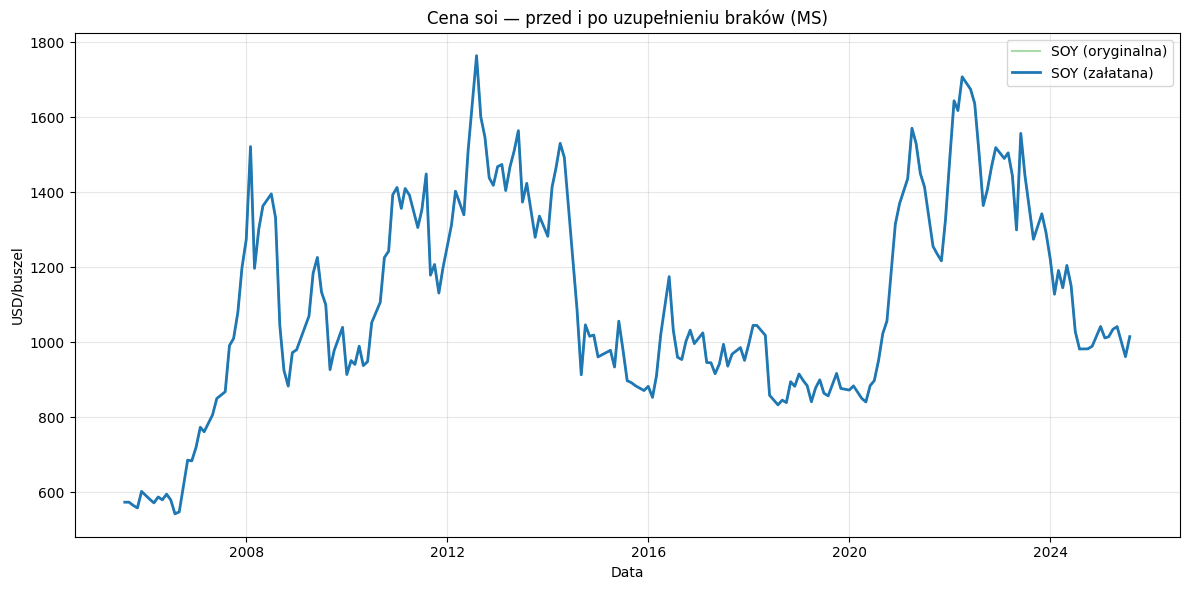

Zapisano serię po uzupełnieniu braków → data\soy_simple_monthly_filled.csv


In [9]:
# %% KROK 1 — wczytaj i ZAŁATAJ DZIURY w SOY (miesięcznie, MS)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- pliki ---
IN_CSV  = os.path.join("data", "soy_simple_monthly.csv")
OUT_CSV = os.path.join("data", "soy_simple_monthly_filled.csv")

# --- wczytaj ---
df = pd.read_csv(IN_CSV, parse_dates=["date"]).set_index("date").sort_index()

if "SOY" not in df.columns:
    raise ValueError("Brak kolumny 'SOY' w pliku wejściowym.")

# --- 1) upewnij się, że indeks to pełna siatka miesięczna (MS) ---
#     (tworzymy pełny grid od pierwszego do ostatniego miesiąca)
start = df.index.min().to_period("M").to_timestamp(how="start")
end   = df.index.max().to_period("M").to_timestamp(how="start")
grid  = pd.date_range(start=start, end=end, freq="MS")
df    = df.reindex(grid)  # wstaw NaN tam, gdzie były „dziury” w miesiącach

# --- 2) zalep dziury TYLKO w SOY ---
#     - najpierw interpolacja liniowa (po czasie)
#     - potem bfill/ffill na brzegach (gdy początek/koniec ma NaN)
soy_orig   = df["SOY"].copy()
soy_interp = soy_orig.interpolate(method="time")
soy_filled = soy_interp.bfill().ffill()

df["SOY"] = soy_filled

# (opcjonalnie) NIE tykamy pozostałych kolumn; jeśli chcesz je też łatać:
# for c in df.columns:
#     if c == "SOY": 
#         continue
#     df[c] = df[c].interpolate(method="time").bfill().ffill()

# --- 3) szybki podgląd różnic ---
print("Liczba braków w SOY (przed):", int(soy_orig.isna().sum()))
print("Liczba braków w SOY (po):   ", int(df['SOY'].isna().sum()))

# --- 4) wykres porównawczy ---
plt.figure(figsize=(12,6))
plt.plot(df.index, soy_orig,   label="SOY (oryginalna)", color="tab:green", alpha=0.4)
plt.plot(df.index, df["SOY"], label="SOY (załatana)",   color="tab:blue",  linewidth=2)
plt.title("Cena soi — przed i po uzupełnieniu braków (MS)")
plt.xlabel("Data"); plt.ylabel("USD/buszel")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

# --- 5) zapisz wynik ---
df.to_csv(OUT_CSV, index_label="date")
print(f"Zapisano serię po uzupełnieniu braków → {OUT_CSV}")


In [16]:
df.to_csv(OUT_CSV, index_label="date")

In [17]:
OUT_CSV

'data\\soy_simple_monthly_filled.csv'

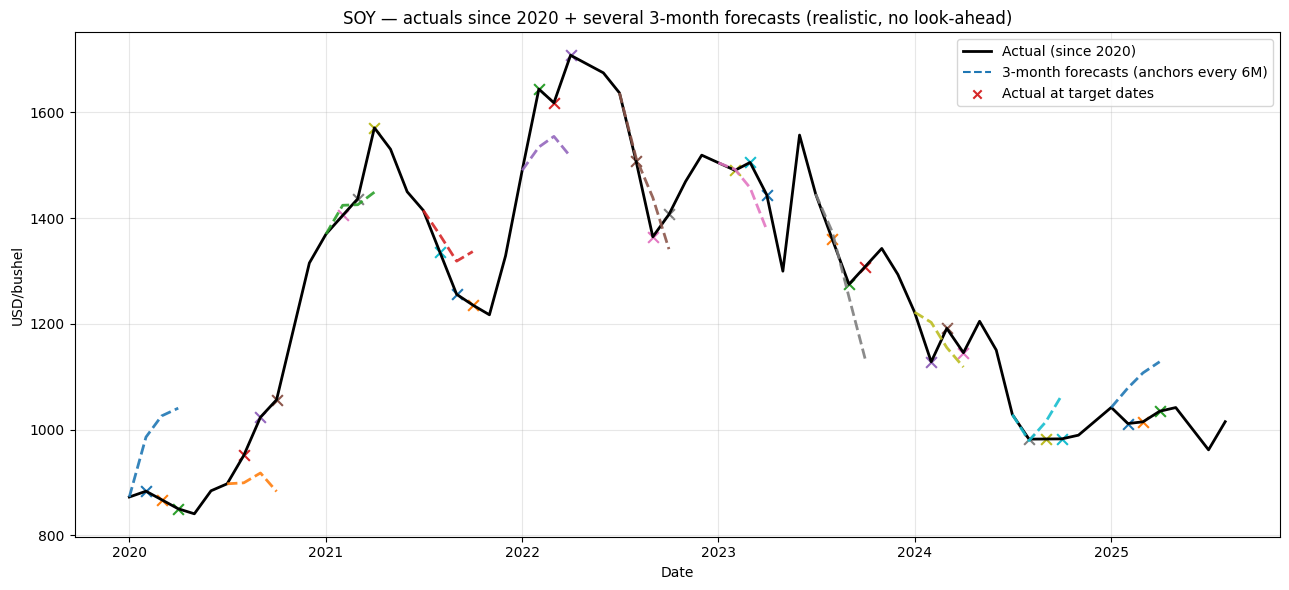

MAE on displayed segments (since 2020):
  horizon h=1: MAE = 43.886 USD/bushel
  horizon h=2: MAE = 64.464 USD/bushel
  horizon h=3: MAE = 117.140 USD/bushel


In [15]:
# %% SOY since 2020 — actuals + several realistic 3-month forecast fans

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# 1) Load filled monthly data (SOY has no gaps)
IN_FILLED = os.path.join("data", "soy_simple_monthly_filled.csv")
df = pd.read_csv(IN_FILLED, parse_dates=["date"]).set_index("date").sort_index()
if "SOY" not in df.columns:
    raise ValueError("Column 'SOY' not found in soy_simple_monthly_filled.csv")

# 2) Features
# Price lags (allow lag0 at anchor)
for L in [0, 1, 2, 3]:
    df[f"SOY_lag{L}"] = df["SOY"].shift(L)

# Exogenous columns (avoid already-lagged columns)
exog_raw = [c for c in df.columns
            if c not in ["SOY"] 
            and not c.startswith("SOY_lag")
            and not (c.endswith("_lag0") or c.endswith("_lag1") or c.endswith("_lag2"))]

for c in exog_raw:
    df[f"{c}_lag0"] = df[c]          # anchor-month info (allowed)
    df[f"{c}_lag1"] = df[c].shift(1)
    df[f"{c}_lag2"] = df[c].shift(2)

# Targets
for h in [1, 2, 3]:
    df[f"SOY_t+{h}"] = df["SOY"].shift(-h)

# Final feature set: only lags
feature_cols = [c for c in df.columns
                if c.startswith("SOY_lag") or c.endswith(("_lag0", "_lag1", "_lag2"))]

pre = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]), feature_cols)
])
def make_model():
    return Pipeline([("pre", pre), ("lin", LinearRegression())])

# 3) Anchors since 2020 (space them for readability)
PLOT_START = pd.Timestamp("2020-01-01")
plot_start = max(PLOT_START, df.index.min())
max_anchor = df.index.max() - pd.DateOffset(months=3)  # need room for t+3
candidates = df.index[(df.index >= plot_start) & (df.index <= max_anchor)]

ANCHOR_STEP_MONTHS = 6  # change to 3/12 for denser/sparser fans
anchor_dates = list(candidates[::ANCHOR_STEP_MONTHS])
if not anchor_dates and len(candidates) > 0:
    anchor_dates = [candidates[-1]]  # fallback if very short series

# 4) For each anchor: train up to (anchor - h) and predict t+1..t+3 (no look-ahead)
segments = []
for anchor in anchor_dates:
    per_h = {}
    for h in [1, 2, 3]:
        y_col = f"SOY_t+{h}"
        df_h = df.dropna(subset=feature_cols + [y_col]).copy()

        cutoff = anchor - pd.DateOffset(months=h)  # strict no-leak
        train = df_h.loc[:cutoff]
        if len(train) < 36:
            continue

        model = make_model()
        model.fit(train[feature_cols], train[y_col])

        if anchor not in df.index:
            continue
        X_anchor = df.loc[[anchor], feature_cols]
        y_hat = float(model.predict(X_anchor)[0])

        target_date = anchor + pd.DateOffset(months=h)
        y_act = float(df.loc[target_date, "SOY"]) if target_date in df.index else np.nan

        per_h[h] = {"target": target_date, "forecast": y_hat, "actual": y_act}

    if set(per_h.keys()) == {1, 2, 3}:
        segments.append({
            "anchor": anchor,
            "p0": float(df.loc[anchor, "SOY"]),
            "t1": per_h[1]["target"], "f1": per_h[1]["forecast"], "a1": per_h[1]["actual"],
            "t2": per_h[2]["target"], "f2": per_h[2]["forecast"], "a2": per_h[2]["actual"],
            "t3": per_h[3]["target"], "f3": per_h[3]["forecast"], "a3": per_h[3]["actual"],
        })

if not segments:
    raise RuntimeError("No complete 3-month forecast segments since 2020. Check data coverage.")

seg_df = pd.DataFrame(segments).sort_values("anchor")

# 5) Plot: actuals since 2020 + several 3-month forecast fans
plt.figure(figsize=(13, 6))

hist = df["SOY"].loc[plot_start: df.index.max()]
plt.plot(hist.index, hist.values, color="black", linewidth=2, label="Actual (since 2020)")

for _, row in seg_df.iterrows():
    xs = [row["anchor"], row["t1"], row["t2"], row["t3"]]
    ys = [row["p0"],     row["f1"], row["f2"], row["f3"]]
    plt.plot(xs, ys, linestyle="--", linewidth=2, alpha=0.9)

    # mark actual outcomes at targets (if present)
    for t_key, a_key in [("t1","a1"), ("t2","a2"), ("t3","a3")]:
        if pd.notna(row[a_key]):
            plt.scatter([row[t_key]], [row[a_key]], marker="x", s=60)

plt.plot([], [], linestyle="--", color="C0",
         label=f"3-month forecasts (anchors every {ANCHOR_STEP_MONTHS}M)")
plt.scatter([], [], marker="x", color="C3", label="Actual at target dates")

plt.title("SOY — actuals since 2020 + several 3-month forecasts (realistic, no look-ahead)")
plt.xlabel("Date"); plt.ylabel("USD/bushel")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 6) MAE by horizon for the displayed segments
def mae(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.nanmean(np.abs(a - b)))

errs = {}
for h in [1, 2, 3]:
    a_vals = seg_df[f"a{h}"].values
    f_vals = seg_df[f"f{h}"].values
    mask = ~np.isnan(a_vals)
    if mask.any():
        errs[h] = mae(a_vals[mask], f_vals[mask])

if errs:
    print("MAE on displayed segments (since 2020):")
    for h in sorted(errs):
        print(f"  horizon h={h}: MAE = {errs[h]:.3f} USD/bushel")
